# Portfolio Optimization -- A Quadratic Programming Example

Suppose you are given a set of assets with the option to invest a total of \\$1 across all assets. You know the rate of return of each asset as well as the covariance of every pair of assets. How should you invest your \\$1?

First, let's graph the rate of return of each asset:

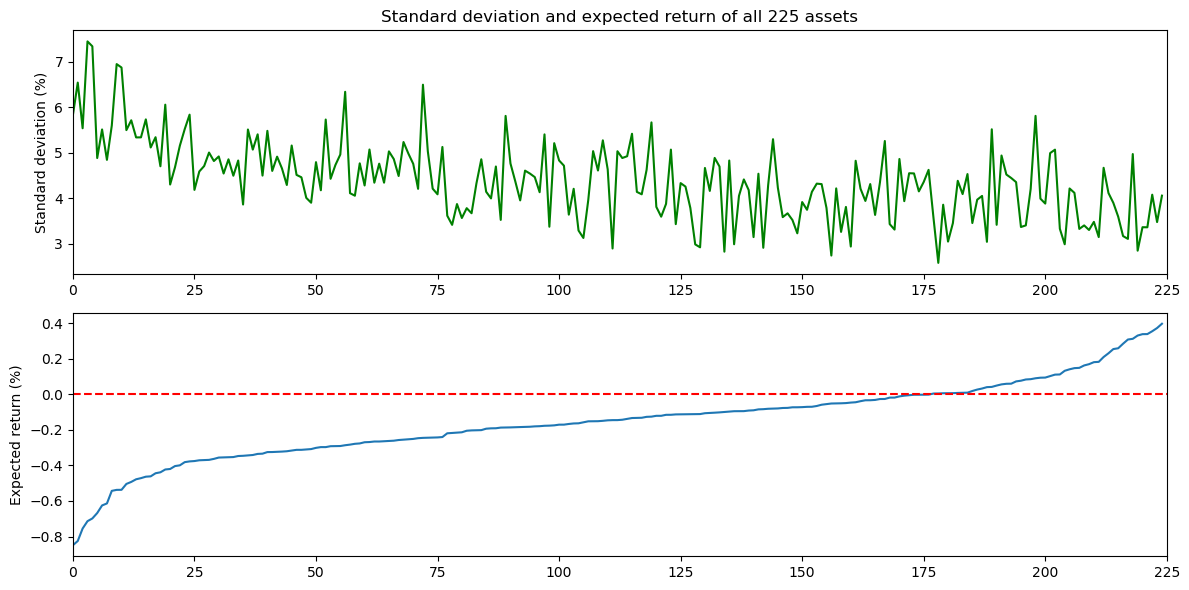

In [1]:
using DataFrames, CSV, LinearAlgebra

df = CSV.read("folio_mean.csv",DataFrame,header=false,delim=',')
r = 100 .*df # Expected return (in percent)
df2 = CSV.read("folio_cov.csv",DataFrame,header=false,delim=',')
Σ = 10000 .*Matrix(df2)# Expected variance (in percent squared)
ix = sortperm(r);   # sort the assets by expected return (this sorts the INDICES)
# plot the rates of return and standard deviation of each of the 225 assets 
using PyPlot
fig = figure(figsize=(12,6))

subplot(211)
xlim(0,225)
plot(sqrt.(diag(Σ))[ix],"g")
ylabel("Standard deviation (%)")
title("Standard deviation and expected return of all 225 assets")
tight_layout()

subplot(212)
xlim(0,225)
plot(Array(r)[ix])
plot([0,225],[0,0],"r--")
ylabel("Expected return (%)")
tight_layout()
;

We can also build a heatmap of the covariance of every pair of assets. Note the diagonal line showing covariance of each asset with itself.

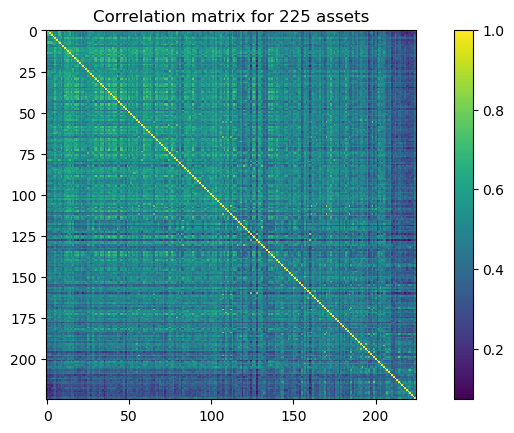

In [2]:
# plot correlation matrix (shows which assets are correlated with which other assets)
corr = diagm(diag(Σ).^(-1/2))*Σ*diagm(diag(Σ).^(-1/2))
imshow(corr[ix,ix]);colorbar();axis("image")
title("Correlation matrix for 225 assets")
;

And plot each asset in terms of rate of return and variance:

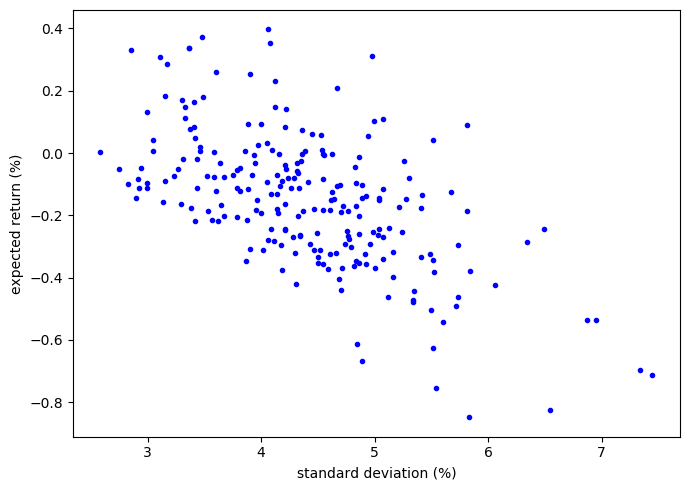

In [3]:
# plot each asset individually
figure(figsize=(7,5))
plot(sqrt.(diag(Σ)), Array(r), "b.")
xlabel("standard deviation (%)")
ylabel("expected return (%)")
tight_layout()

Finally, let's solve the problem:

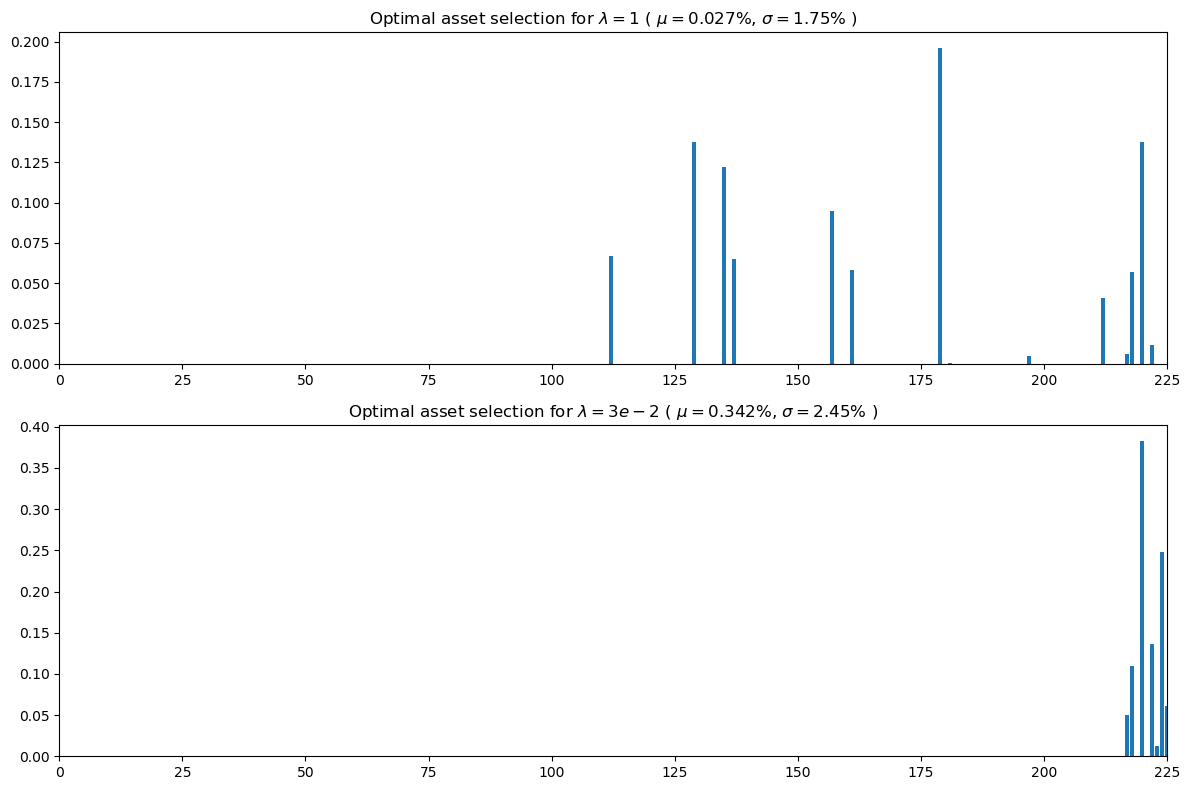

Academic license - for non-commercial use only - expires 2022-06-27


In [4]:
rr = Array(r) # for convenience, convert the data frame r into an Array (rr)

using JuMP, Gurobi
m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "OutputFlag", 0)
@variable(m, x[1:225] >= 0)
@constraint(m, sum(x) == 1)

figure(figsize=(12,8))

subplot(211)

λ = 1 # more weight on risk

@objective(m, Min, -dot(rr,x) + λ*dot(x,Σ*x) ) 
optimize!(m)
xsol = value.(x)
ix1 = findall(xsol .> 1e-4) # pull all xs with positive value
ret = dot(rr,xsol) # calculate rate of return
std = sqrt(dot(xsol,Σ*xsol)) # calculate covariance
xlim(0,225)
bar(1:225,xsol[ix])
title(string("Optimal asset selection for \$\\lambda=1\$"," ( \$\\mu=\$", round(ret,digits=3), "%, \$\\sigma=\$", round(std,digits=2), "% )"));
tight_layout()
subplot(212)

λ = 3e-2 # more weight on return

@objective(m, Min, -dot(rr,x) + λ*dot(x,Σ*x) )
optimize!(m)
xsol = value.(x)
ix2 = findall(xsol .> 1e-4) # pull all xs with positive value
ret = dot(rr,xsol) # calculate rate of return
std = sqrt(dot(xsol,Σ*xsol)) # calculate covariance
xlim(0,225)
bar(1:225,xsol[ix])
title(string("Optimal asset selection for \$\\lambda=3e-2\$"," ( \$\\mu=\$", round(ret,digits=3), "%, \$\\sigma=\$", round(std,digits=2), "% )"));
tight_layout()

In [5]:
# compute optimal tradeoff curve (this may take a few seconds)
N = 50
ret = zeros(N)
sdev = zeros(N)
lambda_values = 10 .^(range(-3,stop=4,length=N))

for (i,λ) in enumerate(lambda_values)
    @objective(m, Min, -dot(rr,x) + λ*dot(x,Σ*x) )
    optimize!(m)
    xsol = value.(x)
    ret[i] = dot(rr,xsol)
    sdev[i] = sqrt(dot(xsol,Σ*xsol))
end


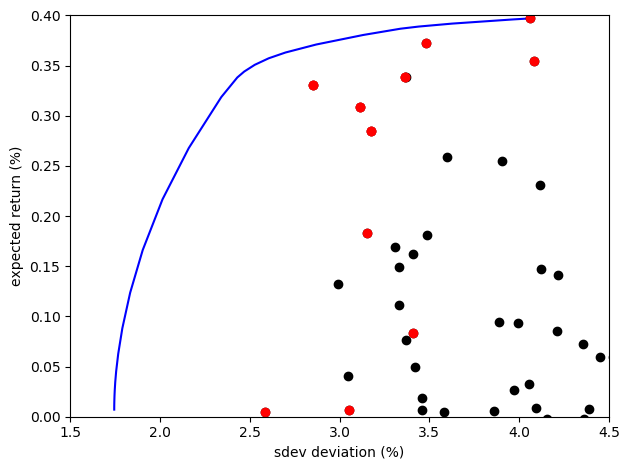

In [6]:
# plot tradeoff curve
plot(sdev,ret,"b-")
plot(sqrt.(diag(Σ)), rr, "k.", markersize=12)
plot(sqrt.(diag(Σ))[ix1], rr[ix1], "r.", markersize=12)  # low-risk portfolio
plot(sqrt.(diag(Σ))[ix2], rr[ix2], "r.", markersize=12)  # at the "elbow" of the curve
xlabel("sdev deviation (%)")
ylabel("expected return (%)")
axis([1.5,4.5,0,.4]);
tight_layout()